## Imports

In [1]:
import sys

import corner
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
from multiprocessing import Pool
from eryn.ensemble import EnsembleSampler
from eryn.moves import CombineMove, GaussianMove, StretchMove, MTDistGenMoveRJ, DistributionGenerateRJ
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State
from eryn.utils import TransformContainer
from eryn.utils.utility import groups_from_inds

from sklearn.model_selection import KFold, train_test_split
from scipy.stats import norm, invgamma

sys.path.append("../../TFM/rk-bfr")
seed = 42
rng = np.random.default_rng(seed)
np.random.seed(seed)

import utils.simulation_utils as simulation
from utils import plot_utils

## Dataset

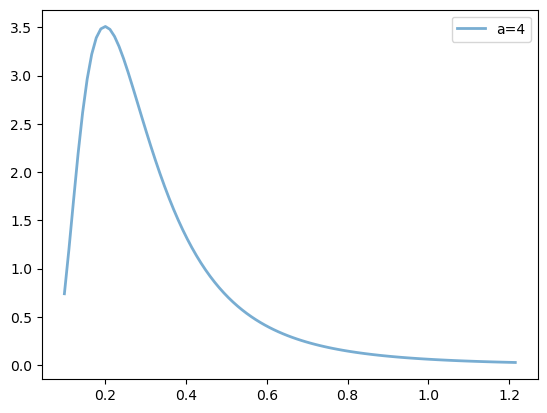

In [2]:
aa=4

x = np.linspace(invgamma.ppf(0.01, aa),
                invgamma.ppf(0.99, aa), 100)
plt.plot(x, invgamma.pdf(x, aa),
        lw=2, alpha=0.6, label=f"a={aa}")
plt.legend()

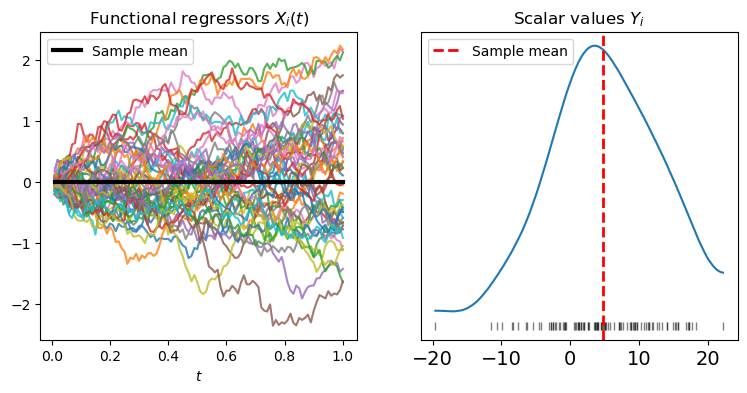

In [3]:
# define true parameters
component_params = np.array(
    [
        [-5, 0.1],
        [10, 0.8],
    ]
)
alpha0 = 5
sigma2 = 0.5

# define dataset parameters
ngrid = 100
n_train, n_test = 100, 50
mean_vector = np.zeros(ngrid)
kernel_fn = simulation.brownian_kernel

# generate regressors and response
t = np.linspace(1.0 / ngrid, 1, ngrid)
x = simulation.gp(t, mean_vector, kernel_fn, n_train + n_test, rng=rng)
y = simulation.generate_rkhs_dataset(
    x, t, component_params.T[0], component_params.T[1], alpha0, sigma2, rng=rng
)

# Train/test split and standardize
X, X_test, Y, Y_test = train_test_split(x, y, train_size=n_train, random_state=seed)
X, X_test = simulation.standardize_predictors(X, X_test)
#Y, Y_test = simulation.standardize_response(Y, Y_test)

# Plot dataset
plot_utils.plot_dataset_regression(
    X,
    Y,
    n_samples=n_train//2,
)

## Model RKHS

**TODO likelihood**

  Vectorize and check if it is faster

In [4]:
def log_likelihood(theta, t, X, y):
    """
    - theta is a list [theta_leaves, theta_common]
        * theta_leaves is an array (p, 2) of the parameters (b_j, t_j) for each component (leaf), where 1<=p<=p_max.
        * theta_common is an array (1, 2) of the parameters alpha_0 and sigma^2, which are common for all models (leaves).
    - t is the grid of shape (ngrid,)
    - X,y are the data, of shape (nfunc, ngrid) and (nfunc,) respectively.
    """
    n = X.shape[0]
    theta_leaves, theta_common = theta
    beta = theta_leaves[:, 0]
    tau = theta_leaves[:, 1]
    alpha0 = theta_common[0][0]
    sigma2 = theta_common[0][1]

    if sigma2 < 0 or np.any(tau < t.min()) or np.any(tau > t.max()):
        return -np.inf

    idx = np.abs(t - tau[:, np.newaxis]).argmin(axis=1)
    X_tau = X[:, idx]
    diff = y - alpha0 - X_tau @ beta
    ll = -n * np.log(np.sqrt(sigma2)) - 0.5*np.einsum('i,i->', diff, diff) / sigma2
  
    return ll

def log_likelihood_vectorize(theta, t, X, y):
    """
    - theta is a list [theta_leaves, theta_common]
        * theta_leaves is an array (p, 2) of the parameters (b_j, t_j) for each component (leaf), where 1<=p<=p_max.
        * theta_common is an array (1, 2) of the parameters alpha_0 and sigma^2, which are common for all models (leaves).
    - t is the grid of shape (ngrid,)
    - X,y are the data, of shape (nfunc, ngrid) and (nfunc,) respectively.
    """
    n = X.shape[0]
    theta_leaves, theta_common = theta
    beta = theta_leaves[:, 0]
    tau = theta_leaves[:, 1]
    alpha0 = theta_common[0][0]
    sigma2 = theta_common[0][1]

    if sigma2 < 0 or np.any(tau < t.min()) or np.any(tau > t.max()):
        return -np.inf

    idx = np.abs(t - tau[:, np.newaxis]).argmin(axis=1)
    X_tau = X[:, idx]
    diff = y - alpha0 - X_tau @ beta
    ll = -n * np.log(np.sqrt(sigma2)) - 0.5*np.einsum('i,i->', diff, diff) / sigma2
  
    return ll

**TODO prior**

1. Prior multivariante en beta FOR ALL LEAVES (parámetro especial prior_all_models)
2. Prior en los beta y en sigma2 escalado según los datos. ¿CÓMO?

In [5]:
class flat_dist():
    def logpdf(self, x):
        return 0

# describes priors for all leaves independently on each branch
# the prior on p (the number of components) is assumed to be uniform in [n_leaves_min,n_leaves_max]
sigma2_param = 2
priors = {
    "components": {
        0: uniform_dist(-50, 50),  # beta
        1: uniform_dist(t.min(), t.max()),  # tau
    },
    "common": {
        0: flat_dist(),  # alpha0
        1: invgamma(sigma2_param)  # sigma2
    }
}

## Sampler

**TODO sampler**

1. Scale of ball around the estimate Y.mean() depends on the data. Same problem as with the prior above.
2. Tune parameters of moves on-the-fly?
3. GroupStretchMove or GaussianMove (does this use the ensemble capabilities?).
4. Check acceptance rate and use it to select optimal scaling parameters on the moves (far from 0 and 1)
5. RJMCMC move (?) --> sample from conditional distribution on the rest of the parameters.
6. Try MultipleTry RJMCMC proposal (check acceptance rate)
7. Label switching; order component means (?)

In [6]:
# set up chain parameters
nwalkers = 16
ntemps = 4
ndims = [2, 2]
nleaves_max = [3, 1]
nleaves_min = [1, 1]
branch_names = ["components", "common"]

coords = {
    branch: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, branch in zip(nleaves_max, ndims, branch_names)
}

# sample initial values for components (b,t) from prior
for nn in range(nleaves_max[0]):
    coords["components"][:, :, nn] = ProbDistContainer(priors["components"]).rvs(size=(ntemps, nwalkers))

# set initial values for alpha0 and sigma2
coords["common"][:, :, 0, 0] = norm(loc=Y.mean(), scale=0.5).rvs(size=(ntemps, nwalkers))
coords["common"][:, :, 0, 1] = invgamma(sigma2_param).rvs(size=(ntemps, nwalkers))

inds = {}
    
inds["components"] = np.random.randint(2, size=(ntemps, nwalkers, nleaves_max[0]), dtype=bool)
# Ensure that not all components are zero on any (ntemp,nwalkers), because nleaves_min = 1
idx = np.where(np.sum(inds["components"], axis=-1) == 0)
inds["components"][*idx, 0] = True

inds["common"] = np.ones((ntemps, nwalkers, nleaves_max[1]), dtype=bool)

In [25]:
# number of steps
nsteps = 1000

# number of cores
njobs = 4

# rj moves
rjmoveMT = MTDistGenMoveRJ(
    {"components": ProbDistContainer(priors["components"])},
    nleaves_max={branch: value for branch, value in zip(branch_names, nleaves_max)},
    nleaves_min={branch: value for branch, value in zip(branch_names, nleaves_min)},
    gibbs_sampling_setup="components", # only perform RJ on the components
    num_try=2,
    rj=True,
)

rjmove = DistributionGenerateRJ(
    {"components": ProbDistContainer(priors["components"])},
    nleaves_max={branch: value for branch, value in zip(branch_names, nleaves_max)},
    nleaves_min={branch: value for branch, value in zip(branch_names, nleaves_min)},
    gibbs_sampling_setup="components",  # only perform RJ on the components
)

# set random seed
np.random.seed(42)

with Pool(njobs) as pool:
    ensemble = EnsembleSampler(
        nwalkers,
        ndims,
        log_likelihood,
        priors,
        args=[t, X, Y],
        pool=pool,
        tempering_kwargs=dict(ntemps=ntemps),
        nbranches=len(branch_names),
        branch_names=branch_names,
        nleaves_max=nleaves_max,
        nleaves_min=nleaves_min,
        moves=StretchMove(),
        rj_moves=rjmoveMT,  # basic generation of new leaves from the prior
    )

    # setup starting state
    state = State(coords, inds=inds)

    # run the sampler
    last_sample = ensemble.run_mcmc(state, nsteps, burn=0, progress=True, thin_by=1)

/home/antcc/.micromamba/envs/python-scientific/lib/python3.11/site-packages/eryn/ensemble.py:442: UserWarning: If using revisible jump, using the Stretch Move for in-model proposals is not advised. It will run and work, but it will not be using the correct complientary group of parameters meaning it will most likely be very inefficient.
  warnings.warn(
100%|██████████| 1000/1000 [00:10<00:00, 93.58it/s]


In [26]:
print(last_sample.branches["components"].nleaves)
print(last_sample.branches["components"].inds[0, 0, :])
print(last_sample.branches_coords["components"][0,0, :])
print(last_sample.branches_coords["common"][0,0, :])

[[2 2 2 2 2 2 2 2 2 2 3 2 3 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2]
 [2 2 2 2 3 2 2 2 2 3 2 3 2 2 2 2]
 [1 1 1 1 2 1 2 1 1 1 1 1 1 2 3 2]]
[False  True  True]
[[ 0.46621332  0.80803294]
 [10.02921398  0.79941219]
 [-4.46832325  0.099351  ]]
[[4.71646642 0.51602016]]


In [27]:
print("Acceptance % (T=1)\n", 100*ensemble.acceptance_fraction[0])
print("RJ Acceptance % (T=1)\n", 100*ensemble.rj_acceptance_fraction[0])

Acceptance % (T=1)
 [ 9.6  9.1  9.9  7.4  9.7  9.9 11.9  8.6  9.8  8.9  9.   8.8  7.3  8.
  7.4 10.4]
RJ Acceptance % (T=1)
 [1.3 1.3 0.8 1.  1.1 1.1 0.3 0.8 0.6 1.  1.2 1.  0.7 0.4 0.4 0.7]


Posterior distribution p|D of the number of components accross all walkers


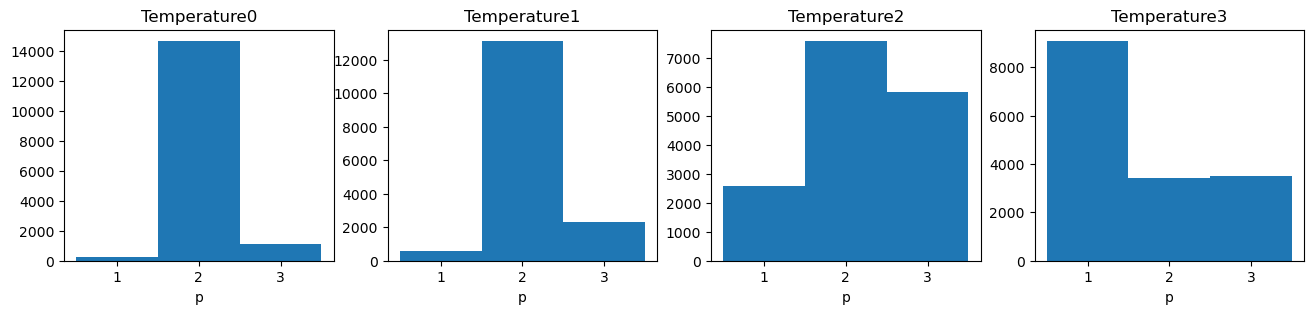

In [20]:
print("Posterior distribution p|D of the number of components accross all walkers")

nleaves = ensemble.get_nleaves()["components"]
bns = (
    np.arange(1, nleaves_max[0] + 2) - 0.5
)  # Just to make it pretty and center the bins

fig, ax = plt.subplots(1, ntemps, figsize=(4 * ntemps, 3))
for temp, ax_t in enumerate(ax):
    ax_t.set_title("Temperature" + str(temp))
    ax_t.set_xlabel("p")
    ax_t.hist(nleaves[:, temp].flatten(), bins=bns)

**TODO** hacer los plots bonitos con todas las variables.

Posterior distribution alpha0|D of the intercept term accross all walkers


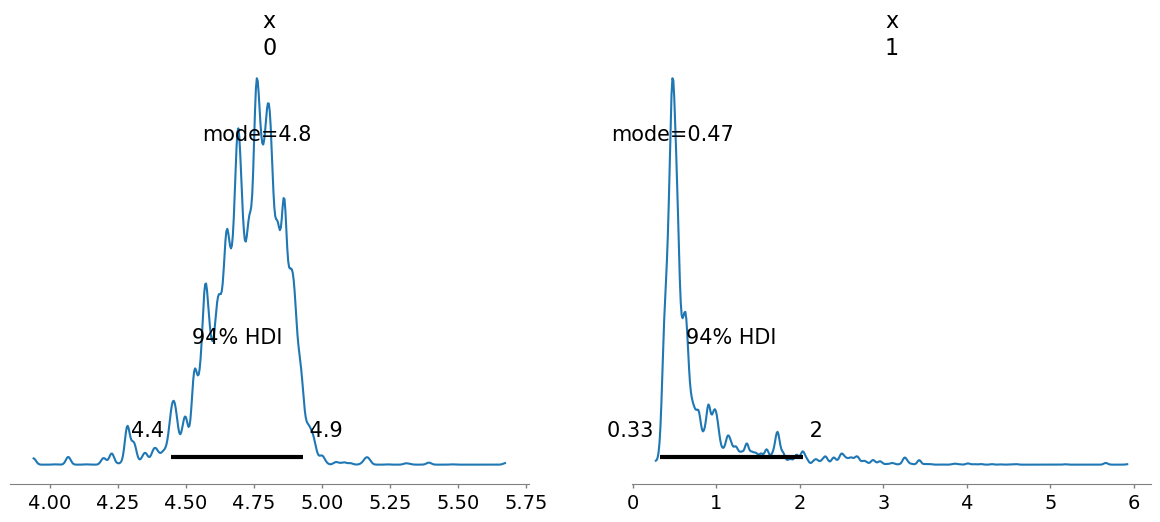

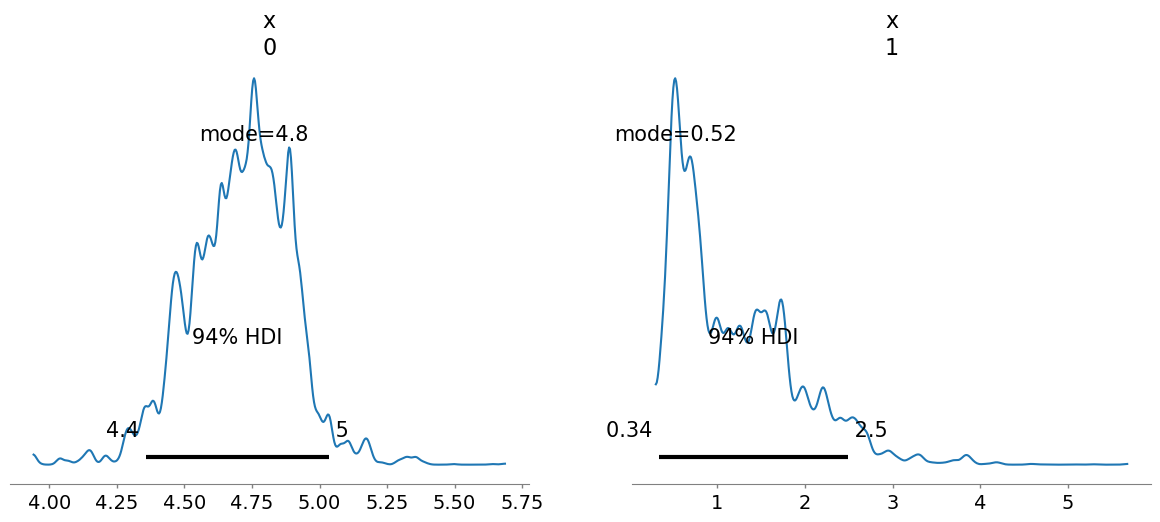

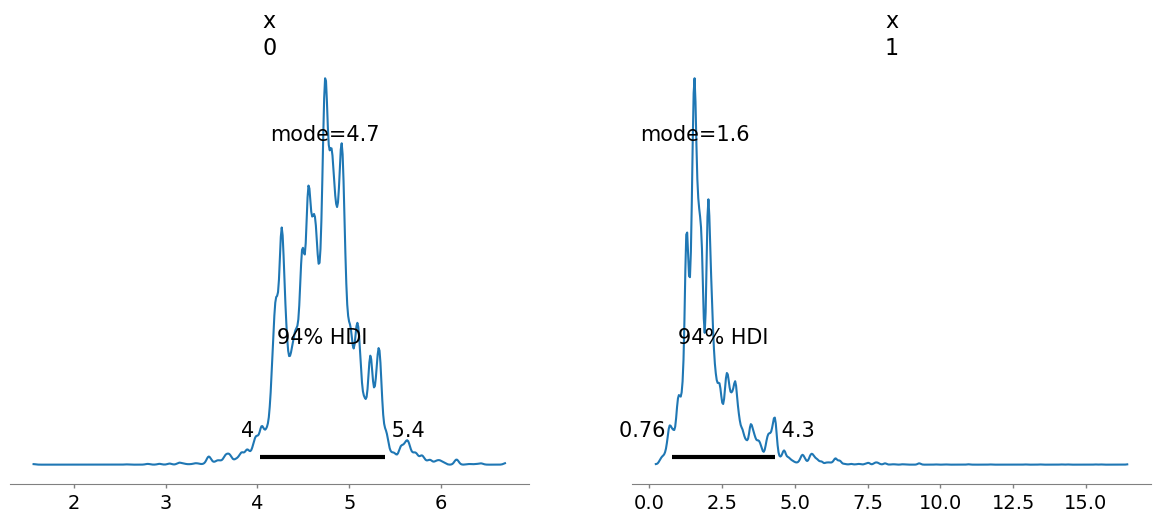

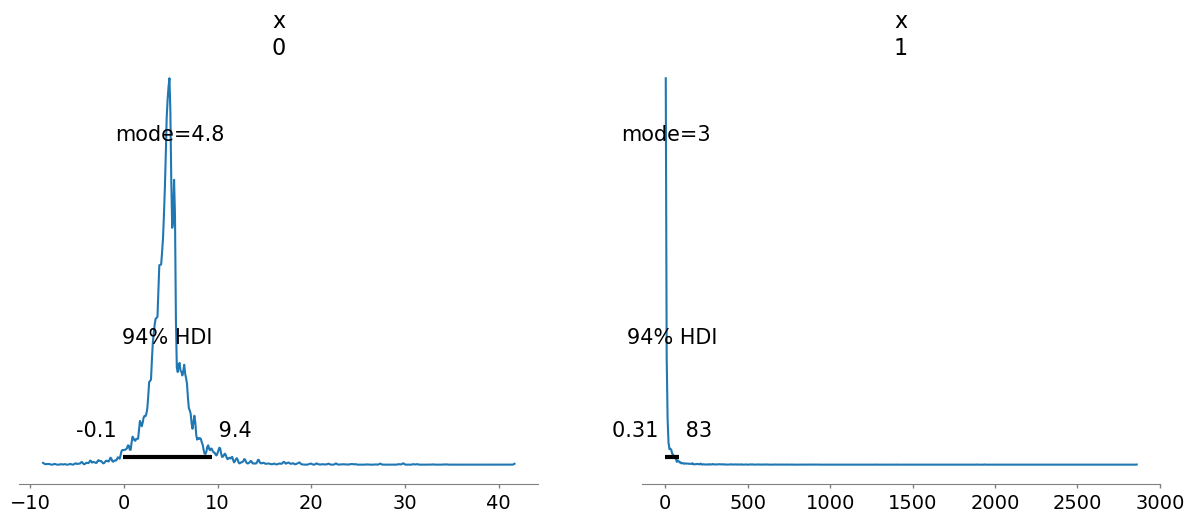

In [21]:
print("Posterior distribution alpha0|D of the intercept term accross all walkers")

common = ensemble.get_chain()["common"].squeeze()
for temp, ax_t in enumerate(ax):
    az.plot_posterior(common[:, temp].swapaxes(0, 1), point_estimate="mode")